# Model Evaluation
Evaluation of saved models

In [1]:
# imports
import torch
import torch.nn as nn
import torch.nn.functional as F

import zipfile
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt

from google.colab import drive

In [2]:
# mount google drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [3]:
# extract data from zip file
import zipfile
import os

# Define the path to your zip file and the directory where you want to extract it
zip_file_path = '/content/drive/MyDrive/465 Project/archive.zip'
extract_folder_path = '/content/data'

os.makedirs(extract_folder_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder_path)

In [4]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [5]:
# Set the directories containing the images and masks
image_dir = '/content/data/Grains'
mask_dir = '/content/data/Segmented'

# Set the target image size
target_size = (IMG_WIDTH, IMG_HEIGHT)

# Create empty lists to hold the images and masks
images = []
masks = []

# Iterate through the directories and load the images and masks
for file in sorted(os.listdir(image_dir)):
    # Load the image and resize to the target size
    img = cv2.imread(os.path.join(image_dir, file))
    img = cv2.resize(img, target_size)

    # Append the resized image to the list of images
    images.append(img)

for file in sorted(os.listdir(mask_dir)):

    # Load the corresponding mask and resize to the target size
    #mask_file = file.replace('.jpg', '.png')
    mask = cv2.imread(os.path.join(mask_dir, file))
    mask = cv2.resize(mask, target_size)

    # Append the resized mask to the list of masks
    masks.append(mask)

# Unet Architecture

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Instantiate the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(IMG_CHANNELS, 1).to(device)

# print(model)

# dataset splitting

In [7]:
# create the X and Y (input and output)

X_train = np.array(images)
Y_train = np.array(masks)
print(X_train.shape, Y_train.shape)
# change the Y to a boolean
Y_train = np.where(Y_train > 245, True, False)

(336, 128, 128, 3) (336, 128, 128, 3)


In [8]:
# careful to run this cell only once (otherwise shape changes)
X_train = np.transpose(X_train, (0, 3, 1 , 2))
Y_train = np.transpose(Y_train, (0, 3, 1 , 2))
print(X_train.shape, Y_train.shape)

(336, 3, 128, 128) (336, 3, 128, 128)


In [9]:
#convert the boolean where it insion s true (any of the 3 channels) to a (336, 128, 128, 1)
#basically reduce the 3 channel dimeRGB to just one boolean value

Y_t= np.any(Y_train, axis=1)
print(Y_t.shape)
Y_t = Y_t.reshape(336, 1, 128, 128)
print(Y_t.shape)


(336, 128, 128)
(336, 1, 128, 128)


# Loading the model with minimum validation loss

In [14]:
# directory where the checkpoints are saved
checkpoint_dir = "/content/drive/MyDrive/465 Project"
min_loss = 100.00
best_ckpt = None
for ckpt in os.listdir(checkpoint_dir):
  if(ckpt.endswith('.pt')):
    temp = torch.load(checkpoint_dir+"/"+ckpt, map_location=torch.device(device))
    if(temp['val_loss'] < min_loss):
      min_loss = temp['val_loss']
      best_ckpt = temp

saved_model_ckpt = best_ckpt
saved_model = UNet(IMG_CHANNELS, 1).to(device)
saved_model.load_state_dict(saved_model_ckpt['model_state_dict'])
epoch = saved_model_ckpt['epoch']
train_loss = saved_model_ckpt['train_loss']
val_loss = saved_model_ckpt['val_loss']
saved_model.eval()
print(train_loss, val_loss)

0.26247009857377007 0.29139534515493054


In [38]:
# Perform predictions on training and validation data
with torch.no_grad():
    if device == 'cpu':
        preds_tensor = saved_model(torch.tensor(X_train, dtype=torch.float32).cpu())
    else:
        preds_tensor = saved_model(torch.tensor(X_train, dtype=torch.float32).cuda())

# Convert predictions to numpy arrays and apply thresholding
preds_np = (preds_tensor.cpu().numpy() > 0.5).astype(np.uint8)

In [39]:
print(preds_np.shape)


(336, 1, 128, 128)


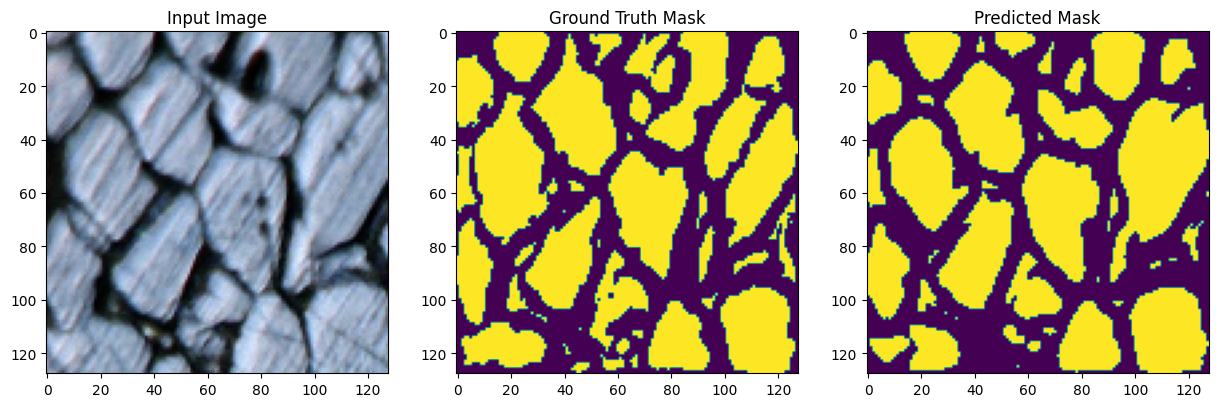

In [41]:
def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Select a random index for demonstration
idx = random.randint(0, len(X_train))

# Display results for the selected index
display_results(X_train[idx], Y_t[idx], preds_np[idx])

In [24]:
!pip install torchmetrics

In [50]:
from torchmetrics.functional import dice

total_dice_score = 0.00

for ind in range(0, len(Y_t)):
  if device=='cpu':
      gt_tensor = torch.tensor(Y_t[ind], dtype=torch.uint8).cpu()
      pred_tensor = torch.tensor(preds_np[ind], dtype=torch.uint8).cpu()
  else:
      gt_tensor = torch.tensor(Y_t[ind], dtype=torch.uint8).cuda()
      pred_tensor = torch.tensor(preds_np[ind], dtype=torch.uint8).cuda()
  dice_score = dice(pred_tensor, gt_tensor)
  total_dice_score=total_dice_score+dice_score
  # print(f"{ind}: {dice_score}")
print(f"Average Dice Score: {total_dice_score/336}")


Average Dice Score: 0.889491856098175
